# Pretrain Data Analysis

训练前的数据分析工作

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
import os
import multiprocessing
import numpy as np
from utilities import mkdir

In [4]:
work_dir = '/data/RaoHiC/results/MISC'
mkdir(work_dir)

导入所有本地所需函数

In [5]:
def pre_analysis(input_file):
    data = np.load(input_file)
    hic = data['hic']
    compact_idx = data['compact']
    chr_len = hic.shape[0]
    cpt_len = len(compact_idx)
    nan_idx = np.ones(hic.shape[0])
    nan_idx[compact_idx] = 0
    nan_percent = np.sum(nan_idx)/len(nan_idx) * 100
    return chr_len, cpt_len, nan_idx, nan_percent

def parallel_pre_analysis(data_dir, chr_list, resolution):
    import time
    pool_num = 23 if multiprocessing.cpu_count() > 23 else multiprocessing.cpu_count()
    pool = multiprocessing.Pool(processes=pool_num)
    print(f'Start a multiprocess pool with process_num = {pool_num}')
    start = time.time()
    results = []
    for n in chr_list:
        input_file = os.path.join(data_dir, f'chr{n}_{resolution}.npz')
        res = pool.apply_async(pre_analysis, (input_file,))
        results.append(res)
    pool.close()
    pool.join()
    print(f'All processes done. Running cost is {(time.time()-start)/60:.1f} min.')
    chr_lens = [r.get()[0] for r in results]
    cpt_lens = [r.get()[1] for r in results]
    nan_idxs = [r.get()[2] for r in results]
    nan_percents = [r.get()[3] for r in results]
    return chr_lens, cpt_lens, nan_idxs, nan_percents

In [6]:
def percentiles(data):
    percents = [80, 85, 90, 95, 99]
    data_pos = data[data>0]
    result = np.percentile(data_pos, percents)
    return result

def wrapped_percentiles(input_file):
    data = np.load(input_file)
    hic = data['hic']
    return percentiles(hic)

def parallel_percentiles(data_dir, chr_list, resolution):
    import time
    pool_num = 23 if multiprocessing.cpu_count() > 23 else multiprocessing.cpu_count()
    pool = multiprocessing.Pool(processes=pool_num)
    print(f'Start a multiprocess pool with process_num = {pool_num}')
    start = time.time()
    results = []
    for n in chr_list:
        input_file = os.path.join(data_dir, f'chr{n}_{resolution}.npz')
        res = pool.apply_async(wrapped_percentiles, (input_file,))
        results.append(res)
    pool.close()
    pool.join()
    print(f'All processes done. Running cost is {(time.time()-start)/60:.1f} min.')
    all_percentiles = [r.get() for r in results]
    return all_percentiles

## GM12878

In [7]:
data_dir = os.path.join('/data/RaoHiC/processing', 'GM12878')
chr_list = list(range(1,23)) + ['X']
high_res = '10kb'
low_res  = '40kb'

载入所需数据，以及其非NaN的位置

In [8]:
chr_lens, cpt_lens, nan_idxs, nan_percents = parallel_pre_analysis(data_dir, chr_list, high_res)

Start a multiprocess pool with process_num = 23
All processes done. Running cost is 0.3 min.


In [9]:
print(f'Chr length: {chr_lens}')
print(f'Chr_cpt length: {cpt_lens}')

Chr length: [24950, 24325, 19820, 19120, 18107, 17118, 15920, 14640, 14130, 13566, 13510, 13398, 11520, 10736, 10263, 9040, 8127, 7816, 5916, 6307, 4815, 5136, 15536]
Chr_cpt length: [22102, 23601, 19456, 18710, 17565, 16711, 15302, 14131, 11111, 12868, 13055, 13024, 9554, 8745, 7847, 7662, 7673, 7468, 5529, 5944, 3432, 3350, 14857]


可以查看一下 NaN 所占的比例，以及哪些位置是 NaN。

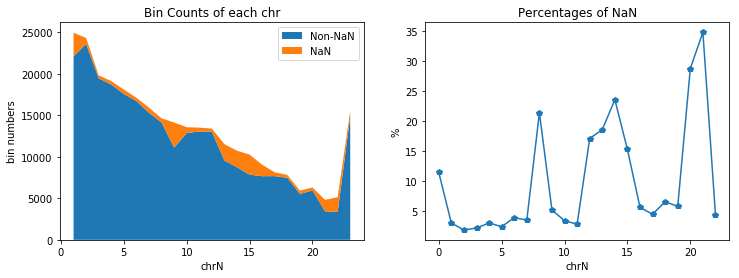

In [10]:
nan_lens = [chr_lens[i]-cpt_lens[i] for i in range(len(chr_list))]
fig = plt.figure(figsize=[12, 4])
ax = fig.add_subplot(1, 2, 1)
ax.stackplot(range(1, len(chr_list)+1), cpt_lens, nan_lens, labels=['Non-NaN', 'NaN'])
ax.set(title='Bin Counts of each chr', xlabel='chrN', ylabel='bin numbers')
ax.legend()
ax = fig.add_subplot(1, 2, 2)
ax.plot(nan_percents, '-p')
ax.set(title='Percentages of NaN', xlabel='chrN', ylabel='%');

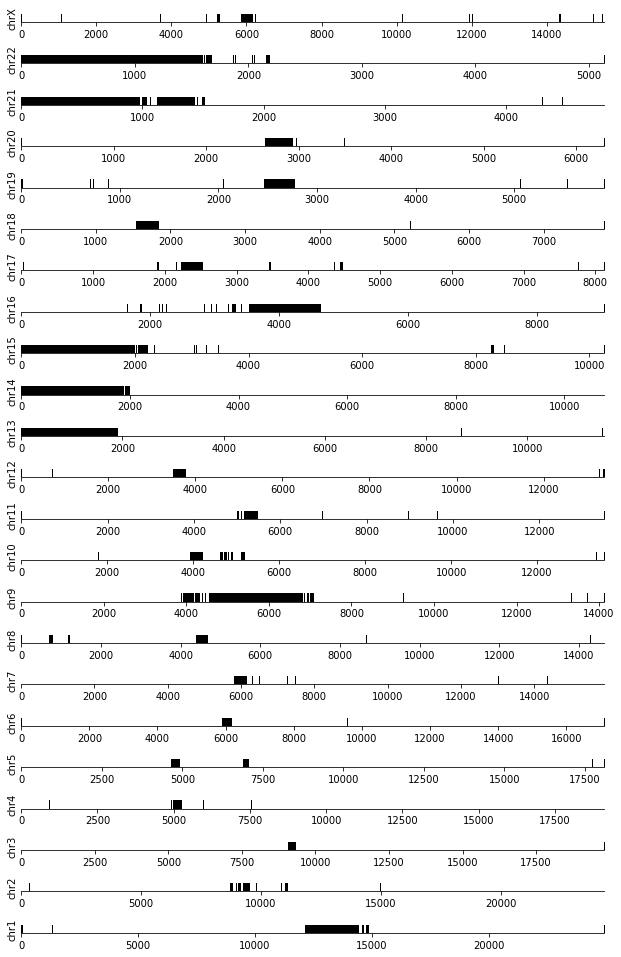

In [11]:
barprops = dict(aspect='auto', cmap=plt.cm.binary, interpolation='nearest')
fig = plt.figure(figsize = (9, len(chr_list)/10))
for i in range(len(chr_list)):
    idx = nan_idxs[i].reshape(1, -1)
    ax = fig.add_subplot(i+1, 1, 1)
    ax.set(ylabel=f'chr{chr_list[i]}', yticks=[])
    ax.set_position((0.1, 0.25*(i+1), 0.9, 0.05))
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.imshow(idx, **barprops)

In [12]:
all_percentiles = parallel_percentiles(data_dir, chr_list, high_res)
down_percentiles = parallel_percentiles(data_dir, chr_list, low_res)

Start a multiprocess pool with process_num = 23
All processes done. Running cost is 0.4 min.
Start a multiprocess pool with process_num = 23
All processes done. Running cost is 0.3 min.


In [ ]:
all_percentiles = np.array(all_percentiles).T
down_percentiles = np.array(down_percentiles).T
percents = [80, 85, 90, 95, 99]
fig = plt.figure(figsize=[12, 4])
ax = fig.add_subplot(1, 2, 1)
for i, p in enumerate(percents):
    ax.plot(all_percentiles[i], '-p', label=f'{p}-percentile')
ax.set_title('Percentiles\' Distribution across all chrs [10kb]')
ax.legend()
ax = fig.add_subplot(1, 2, 2)
for i, p in enumerate(percents):
    ax.plot(down_percentiles[i], '-p', label=f'{p}-percentile')
ax.set_title('Percentiles\' Distribution across all chrs [40kb]')
ax.legend();

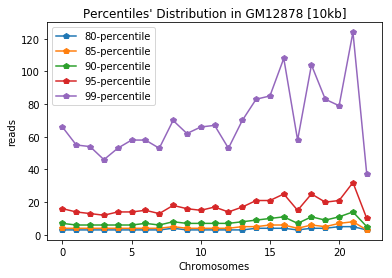

In [13]:
all_percentiles = np.array(all_percentiles).T
down_percentiles = np.array(down_percentiles).T
percents = [80, 85, 90, 95, 99]
fig, ax = plt.subplots()
for i, p in enumerate(percents):
    ax.plot(all_percentiles[i], '-p', label=f'{p}-percentile')
ax.set_title('Percentiles\' Distribution in GM12878 [10kb]')
ax.set_ylabel('reads')
ax.set_xlabel('Chromosomes')
ax.legend()
svg_file = os.path.join(work_dir, f'supp_fig_percentile1.svg')
eps_file = os.path.join(work_dir, f'supp_fig_percentile1.eps')
fig.savefig(svg_file, format='svg')
fig.savefig(eps_file, format='eps')

## GM12878R (replicate)

In [14]:
data_dir = os.path.join('/data/RaoHiC/processing', 'GM12878R')
chr_list = list(range(1,23)) + ['X']
high_res = '10kb'
low_res  = '40kb'

载入所需数据，以及其非NaN的位置

In [15]:
chr_lens, cpt_lens, nan_idxs, nan_percents = parallel_pre_analysis(data_dir, chr_list, high_res)

Start a multiprocess pool with process_num = 23
All processes done. Running cost is 0.3 min.


In [16]:
print(f'Chr length: {chr_lens}')
print(f'Chr_cpt length: {cpt_lens}')

Chr length: [24950, 24325, 19820, 19120, 18107, 17118, 15920, 14640, 14130, 13566, 13510, 13398, 11520, 10736, 10263, 9040, 8127, 7816, 5916, 6307, 4815, 5136, 15536]
Chr_cpt length: [22109, 23601, 19458, 18706, 17566, 16711, 15320, 14122, 11091, 12860, 13052, 13025, 9555, 8746, 7850, 7661, 7671, 7468, 5531, 5944, 3437, 3456, 14859]


可以查看一下 NaN 所占的比例，以及哪些位置是 NaN。

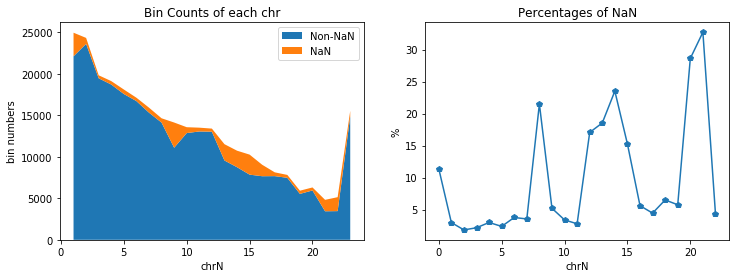

In [17]:
nan_lens = [chr_lens[i]-cpt_lens[i] for i in range(len(chr_list))]
fig = plt.figure(figsize=[12, 4])
ax = fig.add_subplot(1, 2, 1)
ax.stackplot(range(1, len(chr_list)+1), cpt_lens, nan_lens, labels=['Non-NaN', 'NaN'])
ax.set(title='Bin Counts of each chr', xlabel='chrN', ylabel='bin numbers')
ax.legend()
ax = fig.add_subplot(1, 2, 2)
ax.plot(nan_percents, '-p')
ax.set(title='Percentages of NaN', xlabel='chrN', ylabel='%');

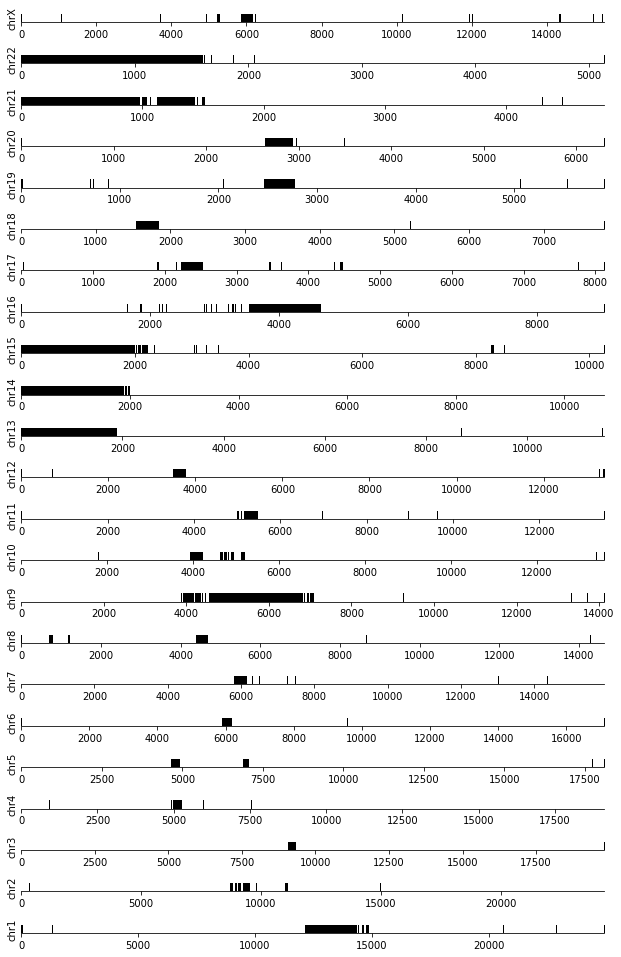

In [18]:
barprops = dict(aspect='auto', cmap=plt.cm.binary, interpolation='nearest')
fig = plt.figure(figsize = (9, len(chr_list)/10))
for i in range(len(chr_list)):
    idx = nan_idxs[i].reshape(1, -1)
    ax = fig.add_subplot(i+1, 1, 1)
    ax.set(ylabel=f'chr{chr_list[i]}', yticks=[])
    ax.set_position((0.1, 0.25*(i+1), 0.9, 0.05))
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.imshow(idx, **barprops)

In [19]:
all_percentiles = parallel_percentiles(data_dir, chr_list, high_res)
down_percentiles = parallel_percentiles(data_dir, chr_list, low_res)

Start a multiprocess pool with process_num = 23
All processes done. Running cost is 0.4 min.
Start a multiprocess pool with process_num = 23
All processes done. Running cost is 0.3 min.


In [ ]:
all_percentiles = np.array(all_percentiles).T
down_percentiles = np.array(down_percentiles).T
percents = [80, 85, 90, 95, 99]
fig = plt.figure(figsize=[12, 4])
ax = fig.add_subplot(1, 2, 1)
for i, p in enumerate(percents):
    ax.plot(all_percentiles[i], '-p', label=f'{p}-percentile')
ax.set_title('Percentiles\' Distribution across all chrs [10kb]')
ax.legend()
ax = fig.add_subplot(1, 2, 2)
for i, p in enumerate(percents):
    ax.plot(down_percentiles[i], '-p', label=f'{p}-percentile')
ax.set_title('Percentiles\' Distribution across all chrs [40kb]')
ax.legend();

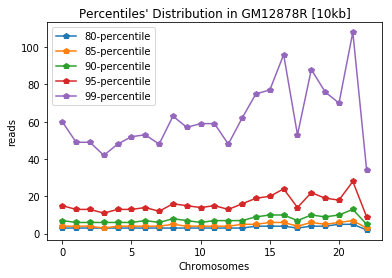

In [20]:
all_percentiles = np.array(all_percentiles).T
down_percentiles = np.array(down_percentiles).T
percents = [80, 85, 90, 95, 99]
fig, ax = plt.subplots()
for i, p in enumerate(percents):
    ax.plot(all_percentiles[i], '-p', label=f'{p}-percentile')
ax.set_title('Percentiles\' Distribution in GM12878R [10kb]')
ax.set_ylabel('reads')
ax.set_xlabel('Chromosomes')
ax.legend()
svg_file = os.path.join(work_dir, f'supp_fig_percentile2.svg')
eps_file = os.path.join(work_dir, f'supp_fig_percentile2.eps')
fig.savefig(svg_file, format='svg')
fig.savefig(eps_file, format='eps')

## K562

In [21]:
data_dir = os.path.join('/data/RaoHiC/processing', 'K562')
chr_list = list(range(1,23)) + ['X']
high_res = '10kb'
low_res  = '40kb'

载入所需数据，以及其非NaN的位置

In [22]:
chr_lens, cpt_lens, nan_idxs, nan_percents = parallel_pre_analysis(data_dir, chr_list, high_res)

Start a multiprocess pool with process_num = 23
All processes done. Running cost is 0.3 min.


In [23]:
print(f'Chr length: {chr_lens}')
print(f'Chr_cpt length: {cpt_lens}')

Chr length: [24950, 24325, 19820, 19120, 18107, 17118, 15920, 14640, 14130, 13566, 13510, 13398, 11520, 10736, 10263, 9040, 8127, 7816, 5916, 6307, 4815, 5136, 15536]
Chr_cpt length: [22101, 23613, 19459, 18726, 17559, 16713, 15321, 14139, 10946, 12863, 13056, 13021, 9550, 8750, 7855, 7652, 7666, 7468, 5533, 5939, 3425, 3336, 14858]


可以查看一下 NaN 所占的比例，以及哪些位置是 NaN。

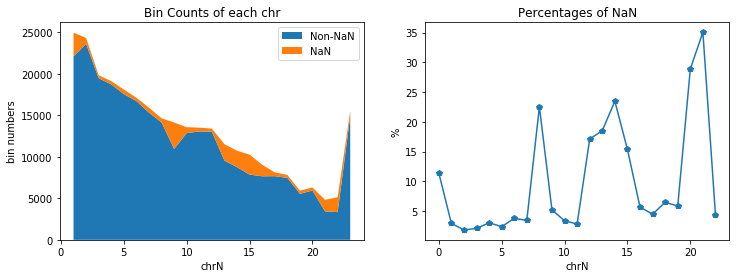

In [24]:
nan_lens = [chr_lens[i]-cpt_lens[i] for i in range(len(chr_list))]
fig = plt.figure(figsize=[12, 4])
ax = fig.add_subplot(1, 2, 1)
ax.stackplot(range(1, len(chr_list)+1), cpt_lens, nan_lens, labels=['Non-NaN', 'NaN'])
ax.set(title='Bin Counts of each chr', xlabel='chrN', ylabel='bin numbers')
ax.legend()
ax = fig.add_subplot(1, 2, 2)
ax.plot(nan_percents, '-p')
ax.set(title='Percentages of NaN', xlabel='chrN', ylabel='%');

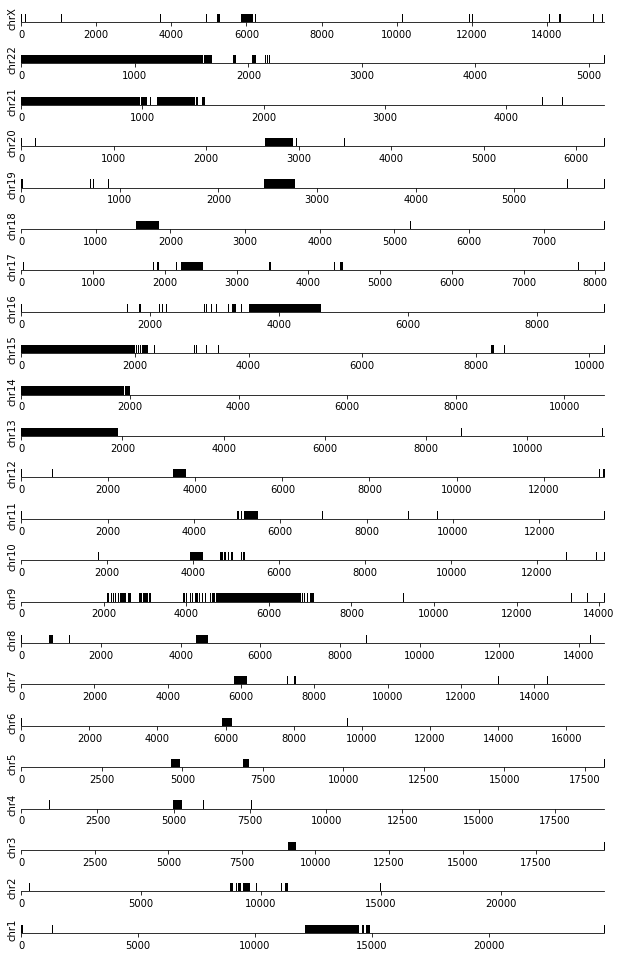

In [25]:
barprops = dict(aspect='auto', cmap=plt.cm.binary, interpolation='nearest')
fig = plt.figure(figsize = (9, len(chr_list)/10))
for i in range(len(chr_list)):
    idx = nan_idxs[i].reshape(1, -1)
    ax = fig.add_subplot(i+1, 1, 1)
    ax.set(ylabel=f'chr{chr_list[i]}', yticks=[])
    ax.set_position((0.1, 0.25*(i+1), 0.9, 0.05))
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.imshow(idx, **barprops)

In [26]:
all_percentiles = parallel_percentiles(data_dir, chr_list, high_res)
down_percentiles = parallel_percentiles(data_dir, chr_list, low_res)

Start a multiprocess pool with process_num = 23
All processes done. Running cost is 0.5 min.
Start a multiprocess pool with process_num = 23
All processes done. Running cost is 0.3 min.


In [ ]:
all_percentiles = np.array(all_percentiles).T
down_percentiles = np.array(down_percentiles).T
percents = [80, 85, 90, 95, 99]
fig = plt.figure(figsize=[12, 4])
ax = fig.add_subplot(1, 2, 1)
for i, p in enumerate(percents):
    ax.plot(all_percentiles[i], '-p', label=f'{p}-percentile')
ax.set_title('Percentiles\' Distribution across all chrs [10kb]')
ax.legend()
ax = fig.add_subplot(1, 2, 2)
for i, p in enumerate(percents):
    ax.plot(down_percentiles[i], '-p', label=f'{p}-percentile')
ax.set_title('Percentiles\' Distribution across all chrs [40kb]')
ax.legend();

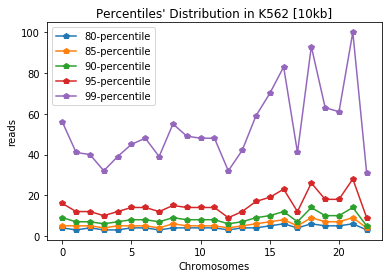

In [27]:
all_percentiles = np.array(all_percentiles).T
down_percentiles = np.array(down_percentiles).T
percents = [80, 85, 90, 95, 99]
fig, ax = plt.subplots()
for i, p in enumerate(percents):
    ax.plot(all_percentiles[i], '-p', label=f'{p}-percentile')
ax.set_title('Percentiles\' Distribution in K562 [10kb]')
ax.set_ylabel('reads')
ax.set_xlabel('Chromosomes')
ax.legend()
svg_file = os.path.join(work_dir, f'supp_fig_percentile3.svg')
eps_file = os.path.join(work_dir, f'supp_fig_percentile3.eps')
fig.savefig(svg_file, format='svg')
fig.savefig(eps_file, format='eps')

## IMR90

In [28]:
data_dir = os.path.join('/data/RaoHiC/processing', 'IMR90')
chr_list = list(range(1,23)) + ['X']
high_res = '10kb'
low_res  = '40kb'

载入所需数据，以及其非NaN的位置

In [29]:
chr_lens, cpt_lens, nan_idxs, nan_percents = parallel_pre_analysis(data_dir, chr_list, high_res)

Start a multiprocess pool with process_num = 23
All processes done. Running cost is 0.3 min.


In [30]:
print(f'Chr length: {chr_lens}')
print(f'Chr_cpt length: {cpt_lens}')

Chr length: [24950, 24325, 19820, 19120, 18107, 17118, 15920, 14640, 14130, 13566, 13510, 13398, 11520, 10736, 10263, 9040, 8127, 7816, 5916, 6307, 4815, 5136, 15536]
Chr_cpt length: [22059, 23596, 19461, 18717, 17572, 16712, 15317, 14138, 11421, 12852, 13049, 13031, 9557, 8756, 7857, 7655, 7680, 7468, 5532, 5941, 3425, 3350, 14853]


可以查看一下 NaN 所占的比例，以及哪些位置是 NaN。

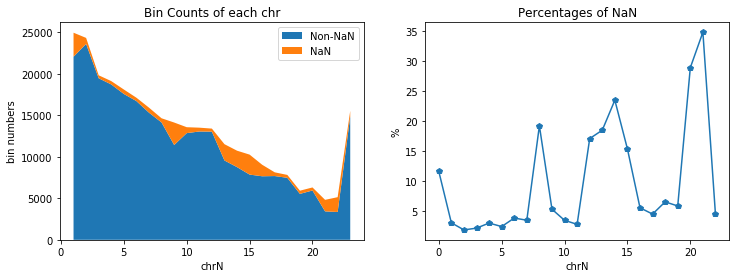

In [31]:
nan_lens = [chr_lens[i]-cpt_lens[i] for i in range(len(chr_list))]
fig = plt.figure(figsize=[12, 4])
ax = fig.add_subplot(1, 2, 1)
ax.stackplot(range(1, len(chr_list)+1), cpt_lens, nan_lens, labels=['Non-NaN', 'NaN'])
ax.set(title='Bin Counts of each chr', xlabel='chrN', ylabel='bin numbers')
ax.legend()
ax = fig.add_subplot(1, 2, 2)
ax.plot(nan_percents, '-p')
ax.set(title='Percentages of NaN', xlabel='chrN', ylabel='%');

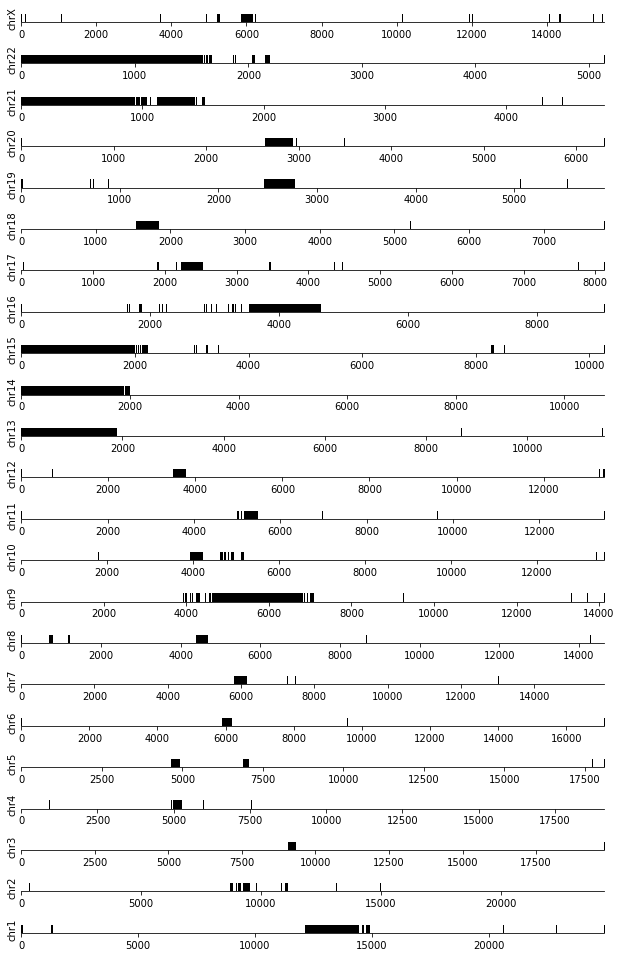

In [32]:
barprops = dict(aspect='auto', cmap=plt.cm.binary, interpolation='nearest')
fig = plt.figure(figsize = (9, len(chr_list)/10))
for i in range(len(chr_list)):
    idx = nan_idxs[i].reshape(1, -1)
    ax = fig.add_subplot(i+1, 1, 1)
    ax.set(ylabel=f'chr{chr_list[i]}', yticks=[])
    ax.set_position((0.1, 0.25*(i+1), 0.9, 0.05))
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.imshow(idx, **barprops)

In [33]:
all_percentiles = parallel_percentiles(data_dir, chr_list, high_res)
down_percentiles = parallel_percentiles(data_dir, chr_list, low_res)

Start a multiprocess pool with process_num = 23
All processes done. Running cost is 0.5 min.
Start a multiprocess pool with process_num = 23
All processes done. Running cost is 0.3 min.


In [ ]:
all_percentiles = np.array(all_percentiles).T
down_percentiles = np.array(down_percentiles).T
percents = [80, 85, 90, 95, 99]
fig = plt.figure(figsize=[12, 4])
ax = fig.add_subplot(1, 2, 1)
for i, p in enumerate(percents):
    ax.plot(all_percentiles[i], '-p', label=f'{p}-percentile')
ax.set_title('Percentiles\' Distribution across all chrs [10kb]')
ax.legend()
ax = fig.add_subplot(1, 2, 2)
for i, p in enumerate(percents):
    ax.plot(down_percentiles[i], '-p', label=f'{p}-percentile')
ax.set_title('Percentiles\' Distribution across all chrs [40kb]')
ax.legend();

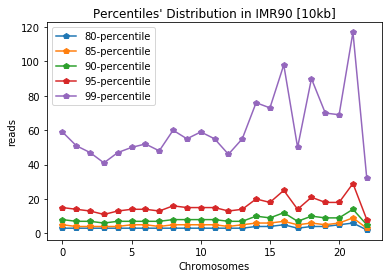

In [34]:
all_percentiles = np.array(all_percentiles).T
down_percentiles = np.array(down_percentiles).T
percents = [80, 85, 90, 95, 99]
fig, ax = plt.subplots()
for i, p in enumerate(percents):
    ax.plot(all_percentiles[i], '-p', label=f'{p}-percentile')
ax.set_title('Percentiles\' Distribution in IMR90 [10kb]')
ax.set_ylabel('reads')
ax.set_xlabel('Chromosomes')
ax.legend()
svg_file = os.path.join(work_dir, f'supp_fig_percentile4.svg')
eps_file = os.path.join(work_dir, f'supp_fig_percentile4.eps')
fig.savefig(svg_file, format='svg')
fig.savefig(eps_file, format='eps')